In [ ]:
!pip install -q transformers
# !pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.0 MB/s eta 0:00:00


In [ ]:
import datetime
import os
import pickle
import random
import sys
import time
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig
from tqdm import tqdm

In [ ]:
def seed_everything(seed):
    # фискирует максимум сидов для корректности сравнения разных экспериментов
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(0xBADBEEF)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # если есть gpu, то gpu
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Очистим данные
def clean_train_data(df):
    df = df[df["date"].dt.year != 1914]

    df = df[~df["text"].isna()]

    classes_to_drop = ["Библиотека", "Оружие", "ЧМ-2014",
                       "Мотор", "МедНовости", "Сочи"]
    df = df[(~df["topic"].isna()) & (~df["topic"].isin(classes_to_drop))]
    return df

# Кодировка таргета
def encoder(df: pd.DataFrame, le: typing.Optional[LabelEncoder] = None) -> LabelEncoder:
    if not le:
        le = LabelEncoder()
        le = le.fit(df.topic)
    df["topic_le"] = le.transform(df.topic)
    return le

In [ ]:
%%shell

if [ ! -f "/content/data/test_50k.csv" ]; then
	mkdir -p /content/data
	test -f /content/data/data.zip || wget --load-cookies /content/data/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /content/data/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1MUygcOKG_eh1XS5jx4kisjGtfx0tZV8r' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1MUygcOKG_eh1XS5jx4kisjGtfx0tZV8r" -O /content/data/data.zip && rm -f /content/data/cookies.txt
	unzip /content/data/data.zip -d /content/data/
	rm -f /content/data/data.zip
fi

--2023-06-25 09:11:21--  https://docs.google.com/uc?export=download&confirm=t&id=1MUygcOKG_eh1XS5jx4kisjGtfx0tZV8r
Resolving docs.google.com (docs.google.com)... 142.251.2.100, 142.251.2.113, 142.251.2.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/aavjmlkoe4p65s734ocdj8se1bvtg04e/1687684275000/08593696392001023704/*/1MUygcOKG_eh1XS5jx4kisjGtfx0tZV8r?e=download&uuid=0b3a5ee8-0bb4-4efd-9b3b-819a06f8fce1 [following]
--2023-06-25 09:11:21--  https://doc-0s-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/aavjmlkoe4p65s734ocdj8se1bvtg04e/1687684275000/08593696392001023704/*/1MUygcOKG_eh1XS5jx4kisjGtfx0tZV8r?e=download&uuid=0b3a5ee8-0bb4-4efd-9b3b-819a06f8fce1
Resolving doc-0s-7k-docs.googleusercontent.com (doc-0s-7k-docs.googleusercontent.com)... 142.251.2.132, 2607:

In [ ]:
TEST_LIMIT = False

with open("/content/data/labelencoder.pkl", 'rb') as file:
    label_encoder = pickle.load(file)

df_train = pd.read_csv("/content/data/train_200k.csv")
if TEST_LIMIT:
  df_train = df_train.iloc[:20000]

df_train["date"] = pd.to_datetime(df_train["date"], format="%Y/%m/%d")
df_train = clean_train_data(df_train)
encoder(df_train, label_encoder)
df_train["title_with_text"] = df_train["title"] + ". " + df_train["text"]

df_test = pd.read_csv("/content/data/test_50k.csv")
if TEST_LIMIT:
  df_test = df_test.iloc[:10000]

df_test["date"] = pd.to_datetime(df_test["date"], format="%Y/%m/%d")
df_test = clean_train_data(df_test)
encoder(df_test, label_encoder)
df_test["title_with_text"] = df_test["title"] + ". " + df_test["text"]

dict_topic = dict(zip(df_test.topic, df_test.topic_le))
dict_topic = dict(sorted(dict_topic.items(), key=lambda item: item[1]))

df_train.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,date,url,topic,tags,title,text,topic_le,title_with_text
0,2000-06-19,https://lenta.ru/news/2000/06/19/dagestan/,Россия,Все,В Дагестан из Чечни пытались пробиться 60 боев...,В воскресенье в Дагестан с территории Чечни пы...,20,В Дагестан из Чечни пытались пробиться 60 боев...
1,2017-12-04,https://lenta.ru/news/2017/12/04/most/,Крым,Все,Движение по мосту в Крым откроется до конца 20...,Крым и Тамань будут соединены автомобильным мо...,8,Движение по мосту в Крым откроется до конца 20...
2,2007-01-17,https://lenta.ru/news/2007/01/17/dylan/,Культура,Все,Боб Дилан переедет в Шотландию,Американский певец Боб Дилан (Bob Dylan) и его...,10,Боб Дилан переедет в Шотландию. Американский п...
3,2016-12-06,https://lenta.ru/news/2016/12/06/dzemal/,Бывший СССР,NaN,Гейдара Джемаля похоронили в Алма-Ате,"Общественного деятеля, председателя Исламского...",3,Гейдара Джемаля похоронили в Алма-Ате. Обществ...
4,2017-06-14,https://lenta.ru/news/2017/06/14/volvokaluga/,Бизнес,Бизнес,Volvo приостановила выпуск экскаваторов в Калуге,Компания Volvo заморозила производство экскава...,2,Volvo приостановила выпуск экскаваторов в Калу...


**Токенизация & Форматирование Input**

In [ ]:
# https://huggingface.co/ai-forever/ruBert-base
# MODEL_NAME = "ai-forever/ruBert-base"
MODEL_NAME = "DeepPavlov/rubert-base-cased"
NUM_LABELS = len(label_encoder.classes_)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)
# model = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True)

Воспользуемся функцией tokenizer

Разобьет предложения на токены.

Добавит специальные токены [CLS] и [SEP].

Заменит токены на их ID.

Приведет все предложения к одной длине - max_len.

Создаст attention masks.


In [ ]:

COLUMN_NAME = "title_with_text"
params = dict(
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    padding='max_length',
    truncation='longest_first',
    max_length=config.max_position_embeddings,
    return_attention_mask=True, # Construct attn. masks.
    return_tensors='pt'
)

train_encoded_data = tokenizer(
    df_train[COLUMN_NAME].tolist(),
    **params
)
# Convert the lists into tensors.
train_input_ids = torch.tensor(train_encoded_data['input_ids'])
train_attention_mask = torch.tensor(train_encoded_data['attention_mask'])
train_labels = torch.tensor(df_train.topic_le.values)

test_encoded_data = tokenizer(
    df_test[COLUMN_NAME].tolist(),
    **params
)
test_input_ids = torch.tensor(test_encoded_data['input_ids'])
test_attention_mask = torch.tensor(test_encoded_data['attention_mask'])
test_labels = torch.tensor(df_test.topic_le.values)

<ipython-input-8-6ace4d5d779e>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_input_ids = torch.tensor(train_encoded_data['input_ids'])
<ipython-input-8-6ace4d5d779e>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_attention_mask = torch.tensor(train_encoded_data['attention_mask'])
<ipython-input-8-6ace4d5d779e>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_input_ids = torch.tensor(test_encoded_data['input_ids'])
<ipython-input-8-6ace4d5d779e>:24: UserWarning: To copy construct from a tensor, it is recommended to

In [ ]:
def create_dataloaders(input_ids, attention_mask, labels, batch_size=16, shuffle=True):
    dataset = TensorDataset(
        torch.tensor(input_ids),
        torch.tensor(attention_mask),
        torch.tensor(labels)
    )
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
    )

train_dataloader = create_dataloaders(train_input_ids, train_attention_mask, train_labels)
test_dataloader = create_dataloaders(test_input_ids, test_attention_mask, test_labels, shuffle=False)

<ipython-input-9-4f4a3b481ebb>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(input_ids),
<ipython-input-9-4f4a3b481ebb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(attention_mask),
<ipython-input-9-4f4a3b481ebb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(labels)


In [ ]:
#@title LightningModule { display-mode: "form" }
# import pytorch_lightning as pl
# from torch.nn.utils.clip_grad import clip_grad_norm_
# from transformers import BertForSequenceClassification
# from torchmetrics.classification import MulticlassF1Score
# from transformers import AdamW, get_linear_schedule_with_warmup

# class SimpleModule(pl.LightningModule):
#     def __init__(self, model, lr=2e-5, eps=1e-8):
#         super().__init__()
#         self.model = model
#         self.optimizer = AdamW(self.model.parameters(), lr=lr, eps=eps)
#         self.metric = MulticlassF1Score(num_classes=NUM_LABELS)
#         self.eps = eps

#     def training_step(self, batch, batch_idx):
#         inputs, masks, labels = batch

#         res = self.model(
#             inputs,
#             token_type_ids=None,
#             attention_mask=masks,
#             labels=labels
#         )

#         loss = res['loss']
#         logits = res['logits']

#         score = self.metric(logits, labels)
#         clip_grad_norm_(model.parameters(), 1.0)

#         self.log(
#             "train_loss",
#             loss.item(),
#             on_step=False, on_epoch=True, prog_bar=True, logger=True
#         )
#         self.log(
#             "train_f1",
#             score,
#             on_step=False, on_epoch=True, prog_bar=True, logger=True
#         )

#         return loss

#     def validation_step(self, batch, batch_idx) -> None:
#         inputs, masks, labels = batch

#         res = self.model(
#             inputs,
#             token_type_ids=None,
#             attention_mask=masks,
#             labels=labels
#         )
#         loss = res['loss']
#         logits = res['logits']

#         score = self.metric(logits, labels)

#         self.log(
#             "test_loss",
#             loss.item(),
#             on_step=False, on_epoch=True, prog_bar=True, logger=True
#         )
#         self.log(
#             "test_f1",
#             score,
#             on_step=False, on_epoch=True, prog_bar=True, logger=True
#         )

#         return loss

#     def configure_optimizers(self):
#         scheduler = get_linear_schedule_with_warmup(
#             self.optimizer,
#             num_warmup_steps=0,
#             num_training_steps=self.trainer.estimated_stepping_batches,
#         )

#         return {
#             "optimizer": self.optimizer,
#             "lr_scheduler": {
#                 "scheduler": scheduler,
#                 "interval": "step",
#                 "frequency": 1
#             },
#             "monitor": "f1"
#         }


# model = BertForSequenceClassification.from_pretrained(
#     MODEL_NAME,
#     num_labels=NUM_LABELS,
#     output_attentions=False, # Whether the model returns attentions weights.
#     output_hidden_states=False, # Whether the model returns all hidden-states.
# )

# # Tell pytorch to run this model on the GPU.
# if accelerator == 'gpu':
#     model.cuda()

# comp = SimpleModule(model).to(device)

# trainer=pl.Trainer(
#     accelerator=accelerator,
#     max_epochs=4
# )

# trainer.fit(comp, train_dataloader, test_dataloader)

Обучение модели

BertForSequenceClassification
Для этой задачи воспользуемся модифицированной весией преобученного BERT'а с дополнительным классификационным слоем поверх основной архитектуры

In [ ]:

def format_time(elapsed):
  # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def train_model(
    model,
    optimizer,
    scheduler,
    train_dataloader,
    validation_dataloader,
    device,
    dict_topic,
    n_epochs=4,
    verbose=True
):
    training_stats = [] # Записываем данные расчета

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    epoch_labels = []
    epoch_preds = []

    # For each epoch...
    for epoch_i in range(0, n_epochs):
        if verbose:
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, n_epochs))
            print('Training...')

        t0 = time.time()
        # Reset the total loss for this epoch.
        total_train_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):
            if verbose and step % 100 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader.
            inputs, masks, labels = batch

            inputs = inputs.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            model.zero_grad()

            res = model(
                inputs,
                token_type_ids=None,
                attention_mask=masks,
                labels=labels
            )
            loss = res['loss']
            logits = res['logits']

            total_train_loss += loss.item()

            loss.backward()
            # Clip the norm of the gradients to 1.0.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader) # loss per epoch
        training_time = format_time(time.time() - t0)

        if verbose:
            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epoch took: {:}".format(training_time))
            print("")
            print("Running Validation...")

        t0 = time.time()
        model.eval()

        # Tracking variables
        epoch_labels = []
        epoch_preds = []
        total_eval_loss = 0
        nb_eval_steps = 0

        for batch in validation_dataloader:
            inputs, masks, labels = batch

            inputs = inputs.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                res = model(
                inputs,
                token_type_ids=None,
                attention_mask=masks,
                labels=labels
            )

            loss = res['loss']
            logits = res['logits']

            total_eval_loss += loss.item()
            # Перевод лейбел и логитов в numpy массивы
            labels_numpy = labels.detach().cpu().numpy()
            logits_numpy = logits.detach().cpu().numpy()
            logits_numpy = np.argmax(logits_numpy, axis=1).flatten()

            epoch_labels = np.append(epoch_labels, labels_numpy)
            epoch_preds = np.append(epoch_preds, logits_numpy)

        val_f1 = f1_score(
            epoch_labels,
            epoch_preds,
            average="weighted",
            zero_division=0
        )

        if verbose:
            print("  f1: {0:.2f}".format(val_f1))

        avg_val_loss = total_eval_loss / len(validation_dataloader)
        validation_time = format_time(time.time() - t0)

        if verbose:
            print("  Validation Loss: {0:.2f}".format(avg_val_loss))
            print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. f1': val_f1,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    if verbose:
        print("")
        print("Training complete!")
        print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

        print(classification_report(epoch_labels, epoch_preds, target_names=dict_topic, zero_division=0))

    return training_stats

In [ ]:
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

EPOCHS = 4

model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    output_attentions=False, # Whether the model returns attentions weights.
    output_hidden_states=False, # Whether the model returns all hidden-states.
)

named_parameters = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(named_parameters)))
for p in named_parameters[-20:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

param_to_train_list = (
    'classifier',
    'bert.pooler',
    'bert.encoder.layer.11',
    'bert.encoder.layer.10',
    'bert.encoder.layer.9',
    'bert.encoder.layer.8',
    'bert.encoder.layer.7',
    'bert.encoder.layer.6',
)
if param_to_train_list:
  print('')
  print('Layers to train:\n')
  for index, param in enumerate(model.bert.parameters()):
      name = named_parameters[index][0]
      if not name.startswith(param_to_train_list):
        param.requires_grad = False
      else:
        print(name)

# Tell pytorch to run this model on the GPU.
if accelerator == 'gpu':
    model.cuda()

optimizer = AdamW(
    model.parameters(),
    lr=2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
    eps=1e-8 # args.adam_epsilon  - default is 1e-8.
)
total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * EPOCHS
)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

The BERT model has 201 different named parameters.

bert.encoder.layer.11.attention.self.query.weight         (768, 768)
bert.encoder.layer.11.attention.self.query.bias               (768,)
bert.encoder.layer.11.attention.self.key.weight           (768, 768)
bert.encoder.layer.11.attention.self.key.bias                 (768,)
bert.encoder.layer.11.attention.self.value.weight         (768, 768)
bert.encoder.layer.11.attention.self.value.bias               (768,)
bert.encoder.layer.11.attention.output.dense.weight       (768, 768)
bert.encoder.layer.11.attention.output.dense.bias             (768,)
bert.encoder.layer.11.attention.output.LayerNorm.weight       (768,)
bert.encoder.layer.11.attention.output.LayerNorm.bias         (768,)
bert.encoder.layer.11.intermediate.dense.weight          (3072, 768)
bert.encoder.layer.11.intermediate.dense.bias                (3072,)
bert.encoder.layer.11.output.dense.weight                (768, 3072)
bert.encoder.layer.11.output.dense.bias            

Ниже привдены эксперименты с разными гиперпараметирами модели.

Здесь лучший вариант модели, и приведен результат уже для модели обученной на 200К данных и тестовые данные - 50К.

**Итоговый скор - f1_weighted = 0.89**

In [ ]:
train_model(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    validation_dataloader=test_dataloader,
    device=device,
    dict_topic=dict_topic,
    n_epochs=EPOCHS
)


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  12,462.    Elapsed: 0:00:27.
  Batch   200  of  12,462.    Elapsed: 0:00:50.
  Batch   300  of  12,462.    Elapsed: 0:01:14.
  Batch   400  of  12,462.    Elapsed: 0:01:37.
  Batch   500  of  12,462.    Elapsed: 0:02:01.
  Batch   600  of  12,462.    Elapsed: 0:02:24.
  Batch   700  of  12,462.    Elapsed: 0:02:48.
  Batch   800  of  12,462.    Elapsed: 0:03:11.
  Batch   900  of  12,462.    Elapsed: 0:03:35.
  Batch 1,000  of  12,462.    Elapsed: 0:03:58.
  Batch 1,100  of  12,462.    Elapsed: 0:04:22.
  Batch 1,200  of  12,462.    Elapsed: 0:04:45.
  Batch 1,300  of  12,462.    Elapsed: 0:05:09.
  Batch 1,400  of  12,462.    Elapsed: 0:05:32.
  Batch 1,500  of  12,462.    Elapsed: 0:05:56.
  Batch 1,600  of  12,462.    Elapsed: 0:06:19.
  Batch 1,700  of  12,462.    Elapsed: 0:06:43.
  Batch 1,800  of  12,462.    Elapsed: 0:07:06.
  Batch 1,900  of  12,462.    Elapsed: 0:07:30.
  Batch 2,000  of  12,462.    Elapsed: 0:07:5

[{'epoch': 1,
  'Training Loss': 0.5064778783736185,
  'Valid. Loss': 0.37558260569958657,
  'Valid. Accur.': 0.8692884862491588,
  'Training Time': '0:48:50',
  'Validation Time': '0:05:57'},
 {'epoch': 2,
  'Training Loss': 0.3358169672433394,
  'Valid. Loss': 0.3471287150806909,
  'Valid. Accur.': 0.879497194781653,
  'Training Time': '0:48:47',
  'Validation Time': '0:05:57'},
 {'epoch': 3,
  'Training Loss': 0.26254768583099947,
  'Valid. Loss': 0.3400896724048387,
  'Valid. Accur.': 0.8877185724181839,
  'Training Time': '0:48:47',
  'Validation Time': '0:05:57'},
 {'epoch': 4,
  'Training Loss': 0.2063459212804843,
  'Valid. Loss': 0.35759207878135674,
  'Valid. Accur.': 0.8903087660334423,
  'Training Time': '0:48:46',
  'Validation Time': '0:05:57'}]

In [ ]:
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained('/content/data/bert/')
tokenizer.save_pretrained('/content/data/bert/')

('/content/data/bert/tokenizer_config.json',
 '/content/data/bert/special_tokens_map.json',
 '/content/data/bert/vocab.txt',
 '/content/data/bert/added_tokens.json',
 '/content/data/bert/tokenizer.json')

Эксперименты с небольшим датасетом, чтобы подобрать гиперпараметры модели. ( train = 20К данных/ test = 10К)

Варианты были следующие:

1. модель DeepPavlov ( max_length=512 - максимальная длина обучаемых предложений,все слои заморожены)

 f1_score = 0.8343
2. модель DeepPavlov ( max_length=256, разморожены слои с 8 )

 f1_score =  0.8339
3.  модель DeepPavlov ( max_length=256, разморожены слои с 6)

 f1_score =  0.8371
4.  модель DeepPavlov ( max_length=512, разморожены слои с 6)

  f1_score = 0.8404
5. модель ai-forever/ruBert-base, max_length=512, разморожены слои с 6

  f1_score = 0.8386

Вывод: модель DeepPavlov показала себя лучше, чем модель от ai-forever( Сбер).
Есть тонкая грань между установкой длины предложений ( обучается конечно же лучше с большей длиной предложений, но и время расчета значительно увеличивается). Так же эксперементировалось с количеством размороженных слоев.
В итоге при разморозке половины последних слоев- получается хороший результат.
На этом в силу временных и технических ресурсов эксперименты остановлены.
Думаю если взять весь датсет и обучить - то скор поднимется еще. Либо если все слои разморозить( но тут не факт - тк начальные слои выучивают только самые простые зависимости)







#### max_length=512


```
df_train = df_train.iloc[:20000]
df_test = df_test.iloc[:10000]
params = dict(
    add_special_tokens=True,
    padding='max_length',
    truncation='longest_first',
    max_length=config.max_position_embeddings,
    return_attention_mask=True,
    return_tensors='pt'
)
                   precision    recall  f1-score   support

   69-я параллель       0.93      0.63      0.75        43
           Бизнес       0.44      0.23      0.30        70
      Бывший СССР       0.83      0.90      0.87       768
              Дом       0.72      0.79      0.75       189
    Забота о себе       0.42      0.29      0.34        28
         Из жизни       0.76      0.71      0.73       423
   Интернет и СМИ       0.78      0.79      0.78       577
             Крым       0.00      0.00      0.00         5
    Культпросвет        0.00      0.00      0.00         3
         Культура       0.89      0.89      0.89       574
          Легпром       0.00      0.00      0.00         1
              Мир       0.83      0.86      0.84      1629
       Моя страна       0.68      0.72      0.70        54
  Наука и техника       0.85      0.83      0.84       655
       Нацпроекты       0.88      0.96      0.92        51
      Путешествия       0.86      0.78      0.82       214
           Россия       0.84      0.83      0.83      2092
Силовые структуры       0.80      0.77      0.79       373
            Спорт       0.97      0.97      0.97       859
   Среда обитания       0.63      0.62      0.62       126
         Ценности       0.84      0.88      0.86       191
        Экономика       0.84      0.86      0.85      1052

         accuracy                           0.84      9977
        macro avg       0.67      0.65      0.66      9977
     weighted avg       0.83      0.84      0.83      9977

[{'epoch': 1,
  'Training Loss': 0.9504448646263939,
  'Valid. Loss': 0.6024529569161435,
  'Valid. Accur.': 0.8130308305513625,
  'Training Time': '0:09:47',
  'Validation Time': '0:01:35'},
 {'epoch': 2,
  'Training Loss': 0.44913046430036974,
  'Valid. Loss': 0.5645774157884984,
  'Valid. Accur.': 0.8288542902224787,
  'Training Time': '0:09:46',
  'Validation Time': '0:01:35'},
 {'epoch': 3,
  'Training Loss': 0.24937952640967184,
  'Valid. Loss': 0.6293369302920138,
  'Valid. Accur.': 0.837369677987166,
  'Training Time': '0:09:47',
  'Validation Time': '0:01:35'},
 {'epoch': 4,
  'Training Loss': 0.13381794001197034,
  'Valid. Loss': 0.7248979388857081,
  'Valid. Accur.': 0.83435950771688,
  'Training Time': '0:09:48',
  'Validation Time': '0:01:36'}]
```



#### max_length=256, bert.encoder.layer.8



```
df_train = df_train.iloc[:20000]
df_test = df_test.iloc[:10000]
params = dict(
    add_special_tokens=True,
    padding='max_length',
    truncation='longest_first',
    max_length=config.max_position_embeddings // 2,
    return_attention_mask=True,
    return_tensors='pt'
)
param_to_train_list = (
    'classifier',
    'bert.pooler',
    'bert.encoder.layer.11',
    'bert.encoder.layer.10',
    'bert.encoder.layer.9',
    'bert.encoder.layer.8',
)
                   precision    recall  f1-score   support

   69-я параллель       1.00      0.23      0.38        43
           Бизнес       0.47      0.10      0.16        70
      Бывший СССР       0.85      0.91      0.88       768
              Дом       0.70      0.80      0.75       189
    Забота о себе       0.60      0.21      0.32        28
         Из жизни       0.77      0.71      0.74       423
   Интернет и СМИ       0.78      0.78      0.78       577
             Крым       0.00      0.00      0.00         5
    Культпросвет        0.00      0.00      0.00         3
         Культура       0.86      0.90      0.88       574
          Легпром       0.00      0.00      0.00         1
              Мир       0.84      0.86      0.85      1629
       Моя страна       0.65      0.67      0.66        54
  Наука и техника       0.83      0.86      0.85       655
       Нацпроекты       0.64      0.69      0.66        51
      Путешествия       0.81      0.81      0.81       214
           Россия       0.84      0.83      0.84      2092
Силовые структуры       0.76      0.77      0.76       373
            Спорт       0.98      0.97      0.97       859
   Среда обитания       0.67      0.53      0.59       126
         Ценности       0.85      0.86      0.85       191
        Экономика       0.84      0.86      0.85      1052

         accuracy                           0.84      9977
        macro avg       0.67      0.61      0.62      9977
     weighted avg       0.83      0.84      0.83      9977

[{'epoch': 1,
  'Training Loss': 0.9880640576586104,
  'Valid. Loss': 0.6310609970838786,
  'Valid. Accur.': 0.7944209404796113,
  'Training Time': '0:02:32',
  'Validation Time': '0:00:45'},
 {'epoch': 2,
  'Training Loss': 0.5616652374402478,
  'Valid. Loss': 0.561892060103277,
  'Valid. Accur.': 0.809748901567723,
  'Training Time': '0:02:31',
  'Validation Time': '0:00:45'},
 {'epoch': 3,
  'Training Loss': 0.45479950746207426,
  'Valid. Loss': 0.5309609189295234,
  'Valid. Accur.': 0.8272669625522341,
  'Training Time': '0:02:31',
  'Validation Time': '0:00:45'},
 {'epoch': 4,
  'Training Loss': 0.3946504496773451,
  'Valid. Loss': 0.5172277642563224,
  'Valid. Accur.': 0.8339560168776614,
  'Training Time': '0:02:34',
  'Validation Time': '0:00:45'}]
```



#### max_length=256, bert.encoder.layer.6

```
df_train = df_train.iloc[:20000]
df_test = df_test.iloc[:10000]
params = dict(
    add_special_tokens=True,
    padding='max_length',
    truncation='longest_first',
    max_length=config.max_position_embeddings // 2,
    return_attention_mask=True,
    return_tensors='pt'
)
param_to_train_list = (
    'classifier',
    'bert.pooler',
    'bert.encoder.layer.11',
    'bert.encoder.layer.10',
    'bert.encoder.layer.9',
    'bert.encoder.layer.8',
    'bert.encoder.layer.7',
    'bert.encoder.layer.6',
)
                   precision    recall  f1-score   support

   69-я параллель       0.94      0.37      0.53        43
           Бизнес       0.48      0.20      0.28        70
      Бывший СССР       0.84      0.91      0.87       768
              Дом       0.74      0.74      0.74       189
    Забота о себе       0.48      0.36      0.41        28
         Из жизни       0.77      0.71      0.74       423
   Интернет и СМИ       0.78      0.80      0.79       577
             Крым       0.00      0.00      0.00         5
    Культпросвет        0.00      0.00      0.00         3
         Культура       0.88      0.90      0.89       574
          Легпром       0.00      0.00      0.00         1
              Мир       0.84      0.86      0.85      1629
       Моя страна       0.72      0.70      0.71        54
  Наука и техника       0.84      0.85      0.84       655
       Нацпроекты       0.66      0.78      0.71        51
      Путешествия       0.83      0.82      0.83       214
           Россия       0.85      0.82      0.83      2092
Силовые структуры       0.78      0.77      0.77       373
            Спорт       0.98      0.98      0.98       859
   Среда обитания       0.59      0.61      0.60       126
         Ценности       0.87      0.84      0.86       191
        Экономика       0.84      0.86      0.85      1052

         accuracy                           0.84      9977
        macro avg       0.67      0.63      0.64      9977
     weighted avg       0.84      0.84      0.84      9977

[{'epoch': 1,
  'Training Loss': 0.9480992260584862,
  'Valid. Loss': 0.603286586009348,
  'Valid. Accur.': 0.8063961633567113,
  'Training Time': '0:03:02',
  'Validation Time': '0:00:45'},
 {'epoch': 2,
  'Training Loss': 0.5251763285127249,
  'Valid. Loss': 0.5500559068332689,
  'Valid. Accur.': 0.8266755109121999,
  'Training Time': '0:03:04',
  'Validation Time': '0:00:46'},
 {'epoch': 3,
  'Training Loss': 0.3949936821049208,
  'Valid. Loss': 0.5366015367580053,
  'Valid. Accur.': 0.8338839141542577,
  'Training Time': '0:03:02',
  'Validation Time': '0:00:45'},
 {'epoch': 4,
  'Training Loss': 0.30853543589026167,
  'Valid. Loss': 0.5268483956893667,
  'Valid. Accur.': 0.8371316714691107,
  'Training Time': '0:03:05',
  'Validation Time': '0:00:46'}]
```

#### DeepPavlov/rubert-base-cased, max_length=512, bert.encoder.layer.6

```
df_train = df_train.iloc[:20000]
df_test = df_test.iloc[:10000]
params = dict(
    add_special_tokens=True,
    padding='max_length',
    truncation='longest_first',
    max_length=config.max_position_embeddings,
    return_attention_mask=True,
    return_tensors='pt'
)
param_to_train_list = (
    'classifier',
    'bert.pooler',
    'bert.encoder.layer.11',
    'bert.encoder.layer.10',
    'bert.encoder.layer.9',
    'bert.encoder.layer.8',
    'bert.encoder.layer.7',
    'bert.encoder.layer.6',
)
                   precision    recall  f1-score   support

   69-я параллель       1.00      0.23      0.38        43
           Бизнес       0.43      0.17      0.24        70
      Бывший СССР       0.85      0.91      0.88       768
              Дом       0.70      0.80      0.75       189
    Забота о себе       0.56      0.32      0.41        28
         Из жизни       0.76      0.73      0.74       423
   Интернет и СМИ       0.77      0.83      0.80       577
             Крым       0.00      0.00      0.00         5
    Культпросвет        0.00      0.00      0.00         3
         Культура       0.89      0.90      0.89       574
          Легпром       0.00      0.00      0.00         1
              Мир       0.84      0.86      0.85      1629
       Моя страна       0.60      0.67      0.63        54
  Наука и техника       0.84      0.85      0.85       655
       Нацпроекты       0.73      0.88      0.80        51
      Путешествия       0.83      0.80      0.82       214
           Россия       0.85      0.82      0.84      2092
Силовые структуры       0.80      0.77      0.79       373
            Спорт       0.98      0.97      0.98       859
   Среда обитания       0.65      0.60      0.62       126
         Ценности       0.86      0.89      0.88       191
        Экономика       0.85      0.86      0.86      1052

         accuracy                           0.84      9977
        macro avg       0.67      0.63      0.64      9977
     weighted avg       0.84      0.84      0.84      9977

[{'epoch': 1,
  'Training Loss': 0.9512132764173549,
  'Valid. Loss': 0.6225272153790754,
  'Valid. Accur.': 0.8045012672216196,
  'Training Time': '0:06:27',
  'Validation Time': '0:01:35'},
 {'epoch': 2,
  'Training Loss': 0.5126400832056903,
  'Valid. Loss': 0.5524091468885158,
  'Valid. Accur.': 0.8131732122266975,
  'Training Time': '0:06:25',
  'Validation Time': '0:01:35'},
 {'epoch': 3,
  'Training Loss': 0.3901462043376929,
  'Valid. Loss': 0.5134011408230529,
  'Valid. Accur.': 0.8378412342244169,
  'Training Time': '0:06:24',
  'Validation Time': '0:01:35'},
 {'epoch': 4,
  'Training Loss': 0.30784955492951754,
  'Valid. Loss': 0.5105233413632959,
  'Valid. Accur.': 0.8404907737377835,
  'Training Time': '0:06:25',
  'Validation Time': '0:01:35'}]
```

#### ai-forever/ruBert-base, max_length=512, bert.encoder.layer.6

```
MODEL_NAME = "ai-forever/ruBert-base"
df_train = df_train.iloc[:20000]
df_test = df_test.iloc[:10000]
params = dict(
    add_special_tokens=True,
    padding='max_length',
    truncation='longest_first',
    max_length=config.max_position_embeddings,
    return_attention_mask=True,
    return_tensors='pt'
)
param_to_train_list = (
    'classifier',
    'bert.pooler',
    'bert.encoder.layer.11',
    'bert.encoder.layer.10',
    'bert.encoder.layer.9',
    'bert.encoder.layer.8',
    'bert.encoder.layer.7',
    'bert.encoder.layer.6',
)
                   precision    recall  f1-score   support

   69-я параллель       0.88      0.16      0.27        43
           Бизнес       0.48      0.23      0.31        70
      Бывший СССР       0.83      0.91      0.87       768
              Дом       0.74      0.79      0.76       189
    Забота о себе       0.52      0.54      0.53        28
         Из жизни       0.76      0.74      0.75       423
   Интернет и СМИ       0.78      0.79      0.78       577
             Крым       0.00      0.00      0.00         5
    Культпросвет        0.00      0.00      0.00         3
         Культура       0.88      0.89      0.88       574
          Легпром       0.00      0.00      0.00         1
              Мир       0.84      0.86      0.85      1629
       Моя страна       0.59      0.87      0.70        54
  Наука и техника       0.85      0.83      0.84       655
       Нацпроекты       0.89      0.94      0.91        51
      Путешествия       0.87      0.81      0.84       214
           Россия       0.85      0.82      0.83      2092
Силовые структуры       0.77      0.79      0.78       373
            Спорт       0.99      0.97      0.98       859
   Среда обитания       0.69      0.69      0.69       126
         Ценности       0.87      0.88      0.87       191
        Экономика       0.85      0.86      0.85      1052

         accuracy                           0.84      9977
        macro avg       0.68      0.65      0.65      9977
     weighted avg       0.84      0.84      0.84      9977

[{'epoch': 1,
  'Training Loss': 0.9919891559831308,
  'Valid. Loss': 0.6368765050234894,
  'Valid. Accur.': 0.8039141951501716,
  'Training Time': '0:06:25',
  'Validation Time': '0:01:35'},
 {'epoch': 2,
  'Training Loss': 0.5411746230568396,
  'Valid. Loss': 0.5469978368864992,
  'Valid. Accur.': 0.8183898492592396,
  'Training Time': '0:06:25',
  'Validation Time': '0:01:37'},
 {'epoch': 3,
  'Training Loss': 0.4065040760997976,
  'Valid. Loss': 0.5097395103329267,
  'Valid. Accur.': 0.8389338956872004,
  'Training Time': '0:06:28',
  'Validation Time': '0:01:37'},
 {'epoch': 4,
  'Training Loss': 0.3157135665889106,
  'Valid. Loss': 0.5056139286129903,
  'Valid. Accur.': 0.8386198712635708,
  'Training Time': '0:06:29',
  'Validation Time': '0:01:35'}]
```

#### DeepPavlov/rubert-base-cased, max_length=512, bert.encoder.layer.6, 200k train records, 50k test

```
params = dict(
    add_special_tokens=True,
    padding='max_length',
    truncation='longest_first',
    max_length=config.max_position_embeddings,
    return_attention_mask=True,
    return_tensors='pt'
)
param_to_train_list = (
    'classifier',
    'bert.pooler',
    'bert.encoder.layer.11',
    'bert.encoder.layer.10',
    'bert.encoder.layer.9',
    'bert.encoder.layer.8',
    'bert.encoder.layer.7',
    'bert.encoder.layer.6',
)
                   precision    recall  f1-score   support

   69-я параллель       0.74      0.86      0.80       142
           Бизнес       0.68      0.71      0.70       337
      Бывший СССР       0.91      0.93      0.92      4095
              Дом       0.88      0.86      0.87       897
    Забота о себе       0.81      0.78      0.79       108
         Из жизни       0.83      0.77      0.80      1994
   Интернет и СМИ       0.83      0.85      0.84      2744
             Крым       0.64      0.58      0.61        24
    Культпросвет        0.67      0.14      0.24        14
         Культура       0.91      0.93      0.92      3028
          Легпром       1.00      0.14      0.25         7
              Мир       0.87      0.89      0.88      8248
       Моя страна       0.91      0.89      0.90       263
  Наука и техника       0.92      0.89      0.90      3268
       Нацпроекты       0.93      0.96      0.95       210
      Путешествия       0.89      0.90      0.89       986
           Россия       0.88      0.87      0.88     10480
Силовые структуры       0.85      0.87      0.86      1840
            Спорт       0.98      0.98      0.98      4075
   Среда обитания       0.85      0.85      0.85       658
         Ценности       0.94      0.93      0.94       994
        Экономика       0.90      0.90      0.90      5433

         accuracy                           0.89     49845
        macro avg       0.86      0.79      0.80     49845
     weighted avg       0.89      0.89      0.89     49845

[{'epoch': 1,
  'Training Loss': 0.5064778783736185,
  'Valid. Loss': 0.37558260569958657,
  'Valid. Accur.': 0.8692884862491588,
  'Training Time': '0:48:50',
  'Validation Time': '0:05:57'},
 {'epoch': 2,
  'Training Loss': 0.3358169672433394,
  'Valid. Loss': 0.3471287150806909,
  'Valid. Accur.': 0.879497194781653,
  'Training Time': '0:48:47',
  'Validation Time': '0:05:57'},
 {'epoch': 3,
  'Training Loss': 0.26254768583099947,
  'Valid. Loss': 0.3400896724048387,
  'Valid. Accur.': 0.8877185724181839,
  'Training Time': '0:48:47',
  'Validation Time': '0:05:57'},
 {'epoch': 4,
  'Training Loss': 0.2063459212804843,
  'Valid. Loss': 0.35759207878135674,
  'Valid. Accur.': 0.8903087660334423,
  'Training Time': '0:48:46',
  'Validation Time': '0:05:57'}]
```

In [ ]:
import numpy as np
Training_Loss = np.array([0.5064, 0.3358, 0.2625, 0.2063])
Valid_Loss = np.array([0.3755, 0.3471, 0.3400, 0.357592])

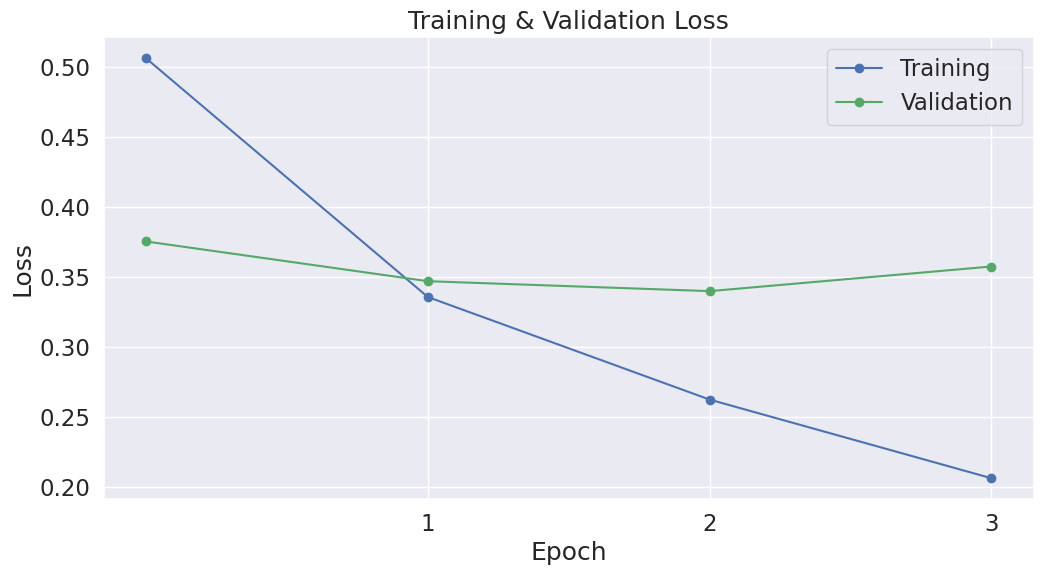

In [ ]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(Training_Loss, 'b-o', label="Training")
plt.plot(Valid_Loss, 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

In [ ]:
Valid_f1_metric = np.array([0.8692, 0.87949, 0.887718, 0.890308])

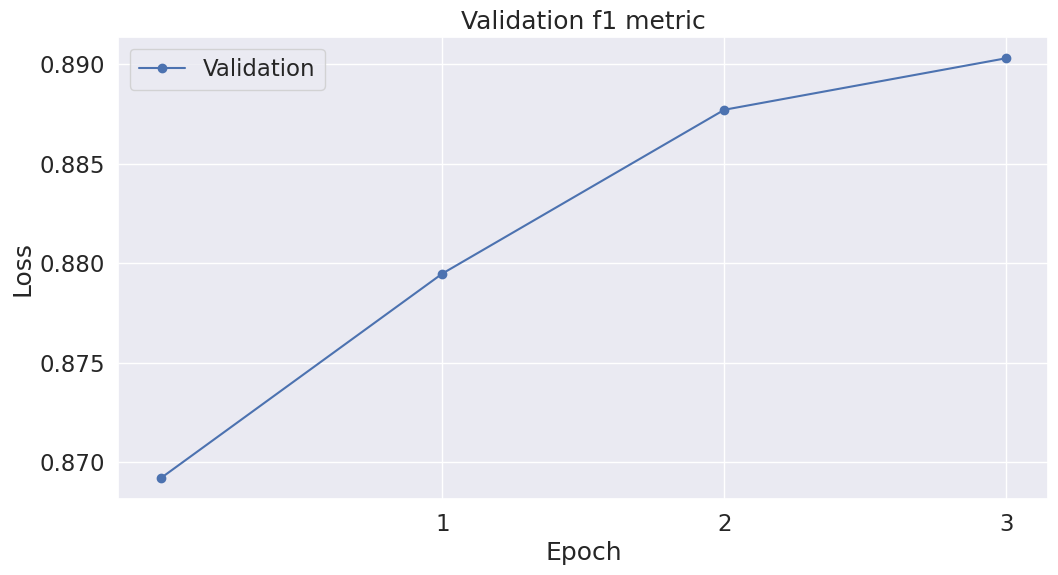

In [ ]:
# Plot the learning curve.
plt.plot(Valid_f1_metric, 'b-o', label="Validation")

# Label the plot.
plt.title("Validation f1 metric")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()